# Variational Quantum Classifier for Heart Disease Prediction

This notebook is our team's submission for the **final capstone project** in the [**Road to Quantum Practitioner**](https://quantum-computing.ibm.com/lab/courses) course organized by **IBM Quantum**.
It implements a **Variational Quantum Classifier (VQC)** to predict heart disease using the UCI Heart Disease dataset.

The project follows a structured pipeline, including:

* **Prerequisites Setup:** Installing and importing all required libraries and tools for Qiskit and quantum computing.
* **Defined Constants:** Declaring all configurable constants for qubit count, optimization method, number of shots, data paths etc.
* **Data Preparation:** Loading and preprocessing the heart disease dataset, including normalization of input features for quantum encoding.
* **Quantum Circuit Preparation:** Designing the quantum feature map, constructing the variational ansatz, and composing the full quantum circuit.
* **Utility Functions:** Implementing helper functions for parameter management, label parsing, and probability extraction from measurement outcomes.
* **Classification and Cost Evaluation:** Defining the classifier and cost functions, including binary cross-entropy (BCE) for training feedback.
* **Execution and Optimization:** Selecting a simulator or real backend, transpiling the circuits, and optimizing parameters using COBYLA or CMA-ES.
* **Result Visualization:** Plotting the evolution of the cost function and testing the trained quantum model on unseen data.

It adheres to modern **Qiskit** practices and is designed for clarity, reproducibility, and experimentation.

## Team members

This project was developed by the following participants of the **IBM Quantum Road to Practitioner** course:

- **Lung Rodica Ioana** - UBB, CSC
- **Mahu Gheorghe** - UMF Iași, CTT
- **Mihoc Tudor-Dan** - UBB, CSC
- **Șofariu Adrian** - UBB
- **Șoptelea Sebastian** - UBB

---

## 📚 Table of Contents

<details>
<summary><strong>Prerequisites</strong></summary>

* [Installing Required Packages](#installing-required-packages)
* [Importing the Packages](#importing-the-packages)

</details>

<details>
<summary><strong>Defined Constants</strong></summary>

* [Defined Constants](#constants)

</details>

<details>
<summary><strong>Data Preparation</strong></summary>

* [Data Normalization for Quantum Encoding](#data-normalization-for-quantum-encoding)

</details>

<details>
<summary><strong>Quantum Circuit Preparation</strong></summary>

* [Quantum Feature Map Initialization](#quantum-feature-map-initialization)
* [Ansatz Circuit Construction](#ansatz-circuit-construction)
* [Quantum Circuit Composition](#quantum-circuit-composition)

</details>

<details>
<summary><strong>Quantum Circuit Utility Functions</strong></summary>

* [Parameter Dictionary Creation for Quantum Circuit](#parameter-dictionary-creation-for-quantum-circuit)
* [Label Assignment Based on Bit String Parity](#label-assignment-based-on-bit-string-parity)
* [Probability Calculation from Quantum Measurement Counts](#probability-calculation-from-quantum-measurement-counts)

</details>

<details>
<summary><strong>Quantum Classification and Cost Functions</strong></summary>

* [Quantum Circuit Classification](#quantum-circuit-classification)
* [Cost Functions](#cost-functions)

  * [BCE Cost](#binary-cross-entropy-cost)
  * [Cost Function for Quantum Circuit Training](#cost-function-for-quantum-circuit-training)

</details>

<details>
<summary><strong>Quantum Execution and Optimization</strong></summary>

* [Backend Setup and Transpilation](#backend-setup-and-transpilation)
* [Quantum Circuit Parameter Optimization](#quantum-circuit-parameter-optimization)

</details>

<details>
<summary><strong>Result Visualization</strong></summary>

* [Cost Function Evolution](#cost-function-evolution)
* [Quantum Classifier Testing](#quantum-classifier-testing)

</details>

---

## **Prerequisites**

### **Installing Required Packages**

To ensure all necessary libraries are available for this notebook, we use `pip` to install the required Python packages. 

This approach guarantees that the environment contains the latest versions of essential tools for quantum computing, data processing, and visualization.  
The `%pip` magic command is used within Jupyter notebooks to install packages directly from a notebook cell, making the setup process straightforward and reproducible.

In [ ]:
# Quantum Computing Framework
%pip install qiskit
%pip install qiskit-aer
%pip install qiskit-ibm-runtime
%pip install qiskit[visualization]

# Data Science and Machine Learning
%pip install scikit-learn
%pip install numpy
%pip install pandas

# Visualization and Plotting
%pip install matplotlib
%pip install matplotlib_inline

# Optimization
%pip install cma

### **Importing the Packages**

Following our installation of the packages, we need to import them to access the required methods and classes in our code. The imports are organized following Python conventions:

- **Standard libraries**: Core Python packages for data manipulation and visualization
- **Third-party and Scikit-learn libraries**: Specialized tools for optimization and machine learning
- **Qiskit libraries**: Quantum computing framework components

In [ ]:
# Standard library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime
import os
import glob

# Third-party optimization libraries
import cma
from scipy.optimize import minimize
import scipy.stats as st

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

# Qiskit imports
import qiskit
from qiskit import generate_preset_pass_manager
from qiskit.circuit.library import real_amplitudes, zz_feature_map
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Session

A small check to ensure everything is okay:

In [ ]:
# Check if Qiskit is installed and print the version
if 'qiskit' in globals():
    print(f"Qiskit version: {qiskit.__version__}") # The version of Qiskit which we are currently using is 2.1.1. In the future, methods and classes may change
                                                   # or become deprecated, so it may be necessary to update the code accordingly.
else:
    print("Qiskit is not installed or not available in the current environment. Re-run the `Installing Required Packages` cell.")

---

## **Constants**

The script uses a set of global constants to control quantum circuit setup, data processing, optimization, and backend selection. These values can be easily modified to experiment with different settings (e.g., changing optimizers, adjusting iteration counts, or switching between real and simulated quantum hardware).

Feel free to tweak them to explore the model's behavior under different conditions.

In [ ]:
# ==== Quantum Circuit Parameters ====
QUBIT_COUNT = 4           # Number of qubits (i.e., input features)
SHOT_COUNT = 1024         # Number of shots (circuit executions per sample)
CLASS_LABELS = ['healthy', 'diseased']  # Binary class labels used for classification

# ==== Dataset and Preprocessing ====
HEART_DATA_PATH = 'heartdata.csv'  # Path to the heart disease dataset CSV
TEST_SIZE = 0.3                    # Test split size (30% for evaluation)

# ==== Reproducibility ====
RANDOM_STATE = 42         # Seed for consistent behavior across runs

# ==== Optimization ====
COBYLA_ITER_COUNT = 2     # Iteration limit for the COBYLA optimizer
CMA_ITER_COUNT = 15       # Iteration limit for the CMA-ES optimizer. !!! May go over this limit due to the check being made at the end of each iteration
USE_CMA = False           # Flag to choose CMA-ES (True) or COBYLA (False)
CMA_POPSIZE = 20          # Population size for CMA-ES (default is 4 + 3 * log(n) where n is the number of parameters)
PRINT_COST = True         # Print cost value at each step if True

# ==== Testing ====
TEST_ITER_COUNT = 3        # Number of test repetitions to average final accuracy

# ==== Backend Selection ====
USE_REAL_BACKEND = False   # If True, use real IBM Quantum backend; else use simulator
REGION = 'eu-de'           # Region for Qiskit Runtime service: 'eu-de' or 'us-east'

---

## **Data Preparation**

### **Data Normalization for Quantum Encoding**

This function loads and normalizes heart disease dataset features and labels for use in quantum machine learning applications.

#### **Source**

According to the paper:  
**[Explainable Artificial Intelligence Framework for Multimodal Data Analysis](https://www.nature.com/articles/s41598-022-24633-4)**,  
the most clinically relevant traits to diagnose cardiac disorders include:  
`cp`, `ca`, `thal`, `age`, `thalach`, `chol`, `oldpeak`, and `sex`.

Of these, the most important are:
- `ca` (number of major vessels colored by fluoroscopy)  
- `cp` (chest pain type)  
- `thal` (thalassemia)  
- `oldpeak` (ST depression induced by exercise)

However, over half of the dataset contains missing values for `ca` and `thal`.  
To preserve as much usable data as possible, we dropped these and selected features from those with minimal nulls.

#### **Feature Selection Rationale**

From the remaining mostly complete columns, we selected:
- `cp` (chest pain type)  
- `oldpeak` (ST depression induced by exercise)  
- `sex` (gender)  
- `exang` (exercise-induced angina)

This decision was reinforced by multiple trials and confirmed during exploratory data analysis in [this notebook](https://github.com/rodneyosodo/variational-quantum-classifier-on-heartattack/blob/main/Src/Notebooks/01dataExploration.ipynb),
where these features consistently ranked among the most defining predictors of heart disease.

#### **Final Selected Features**

- `cp`, `oldpeak`, `sex`, `exang`  
These were chosen to match a 4-qubit quantum model.

#### **Output**

Returns the normalized training and test features and labels as a tuple.  
Features are scaled to `(0, π)` to enable valid angle encoding for quantum gates (e.g. `Ry`, `Rx`).

In [ ]:
def normalize_data() -> tuple:
    """
    Load and normalize heart disease dataset features and labels for quantum machine learning.

    Selected 4 features — 'cp', 'oldpeak', 'sex', and 'exang' — are scaled to the range (0, π) 
    for angle encoding in quantum circuits.

    These features were chosen based on feature importance, data completeness, and validation 
    through exploratory analysis.

    Returns:
        tuple: Normalized (X_train, X_test) features and (Y_train, Y_test) labels.
    """
    # Load dataset and shuffle to randomize sample order
    df = pd.read_csv(HEART_DATA_PATH)
    df = shuffle(df, random_state=RANDOM_STATE)

    # Select top 4 features for 4-qubit quantum encoding
    X = df[['cp', 'oldpeak', 'sex', 'exang']].values
    Y = df['num'].values

    # Split before scaling to avoid data leakage
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    # Normalize inputs between 0 and π for angle encoding
    # The range (0, np.pi) is chosen to ensure that the angles used in quantum circuits are within a valid range for angle encoding.
    # This is important for quantum circuits that use angle encoding (e.g. Rx, Ry gates), as angles outside this range may
    # lead to incorrect results or inefficiencies in the quantum computation.
    scaler = MinMaxScaler(feature_range=(0, np.pi))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, Y_train, Y_test

Obtaining the actual train and test data:

In [ ]:
X_train, X_test, Y_train, Y_test = normalize_data()

---

## **Quantum Circuit Preparation**

### **Quantum Feature Map Initialization**

Initializes a ZZFeatureMap circuit to encode classical input features into a quantum state for machine learning.

#### **Configuration**

* **Initial state**: All qubits set to $|0\rangle$
* **Feature map**: ZZFeatureMap with linear entanglement
* **Repetitions**: 2 layers for increased expressiveness
* **Qubit count**: Equals number of input features

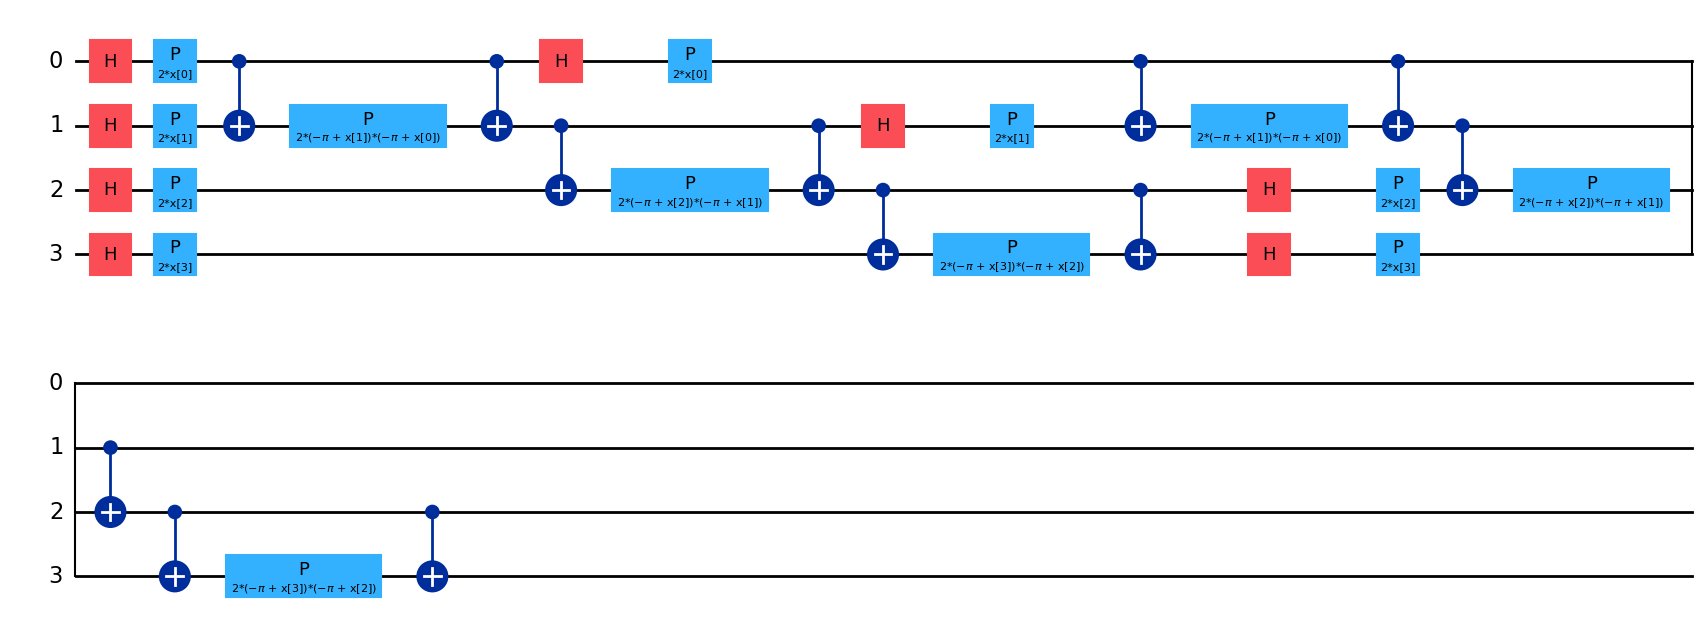

In [44]:
# Prepare the initial quantum state (all qubits in |0⟩ state)
state = Statevector.from_label('0' * QUBIT_COUNT)

# Create the ZZFeatureMap for encoding classical data into quantum states
feature_map = zz_feature_map(
    feature_dimension=QUBIT_COUNT, # Number of features/qubits
    reps=2,                        # Number of repetitions of the feature map circuit
    entanglement='linear'          # How qubits are entangled (linear = nearest neighbors)
)

# Visualize the feature map circuit
feature_map.draw(output='mpl')

### **Ansatz Circuit Construction**

Defines the parameterized quantum circuit (ansatz) used for learning in a variational quantum algorithm.

#### **Configuration**

* **Circuit type**: RealAmplitudes
* **Qubit count**: Matches the feature dimension
* **Entanglement**: Linear pattern
* **Repetitions**: 1 layer of parameterized gates

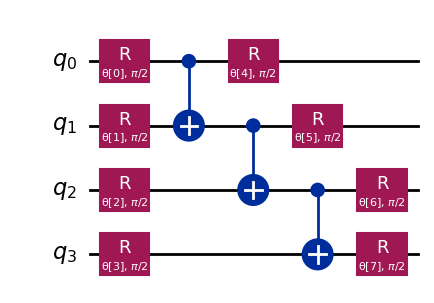

In [45]:
# Prepare the ansatz circuit used for parameterized learning
# This circuit will be optimized during training
ansatz = real_amplitudes(
    num_qubits=QUBIT_COUNT,  # Number of qubits = number of features
    reps=1,                  # One repetition layer of rotations + entanglement
    entanglement='linear'    # Linear entanglement between qubits
)

# Visualize the decomposed circuit
ansatz.decompose().draw(output='mpl')

### **Quantum Circuit Composition**

Combines the data-encoding feature map with the parameterized ansatz circuit.

#### **Configuration**

* **Feature Map**: Encodes classical features into quantum states
* **Ansatz**: Trainable circuit for learning patterns
* **Output Circuit**: Used for quantum machine learning models

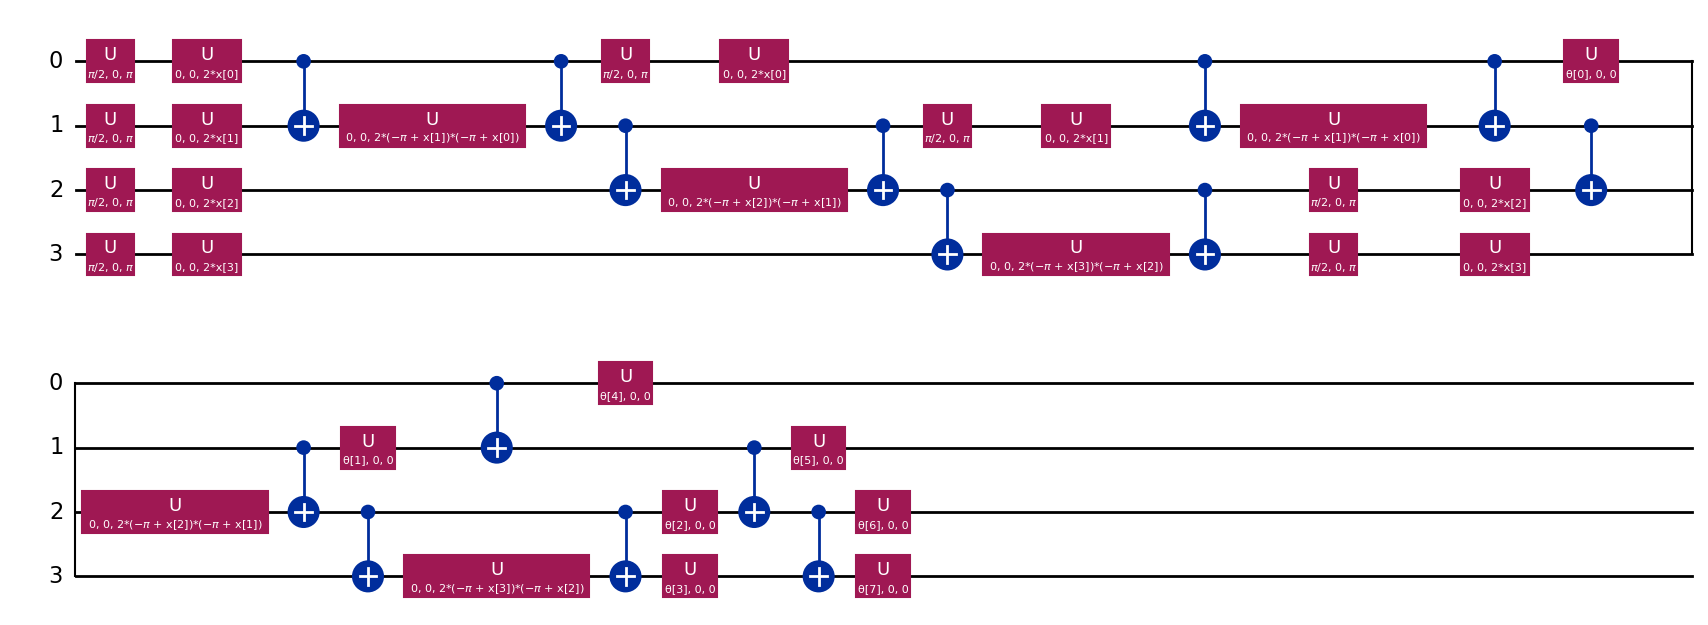

In [46]:
# Compose the full quantum circuit by combining feature map and ansatz
# The feature map encodes the input data; ansatz is the trainable part
circuit = feature_map.compose(ansatz, inplace=False)

# Visualize the decomposed circuit with multiple repetitions for clarity
circuit.decompose(reps=8).draw(output='mpl')

---

## **Quantum Circuit Utility Functions**

### **Parameter Dictionary Creation for Quantum Circuit**

This function creates a dictionary that maps parameters of both the feature map and ansatz circuits to their corresponding values.

#### **Output**

Returns a dictionary that associates each circuit parameter with its value, combining input features for the feature map and weights for the ansatz.  
Used to bind values before running the quantum circuit.

In [47]:
def get_data_dict(params: list, x: list) -> dict:
    """
    Create a dictionary of parameters for the feature map and ansatz.

    Args:
        params (list): List of parameters for the ansatz (trainable weights).
        x (list): List of features for the feature map (input data).

    Returns:
        dict: A dictionary mapping circuit parameters to their corresponding values.
    """
    parameters = {}
    for i, p in enumerate(feature_map.parameters):
        parameters[p] = x[i]  # Bind feature values to feature map parameters
    for i, p in enumerate(ansatz.parameters):
        parameters[p] = params[i]  # Bind trainable ansatz parameters
    return parameters

### **Label Assignment Based on Bit String Parity**

This function assigns a class label by calculating the parity of the Hamming weight (number of 1s) in a given bit string.

#### **Processing Details**

- Computes the Hamming weight of the bit string.
- Determines if the parity (sum of bits) is even or odd.
- Returns the first class label if parity is even, otherwise the second class label.

#### **Output**

Returns a class label based on the parity, useful for interpreting quantum measurement outcomes.

In [48]:
def assign_label(bit_string: str, class_labels: list) -> str:
    """
    Assign a label based on the parity of the Hamming weight of the bit string.
    Args:
        bit_string (str): A string of bits representing the quantum state.
        class_labels (list): A list of class labels, e.g., ['yes', 'no'].
    Returns:
        str: The assigned class label based on the parity of the Hamming weight.
    """
    hamming_weight = sum([int(bit) for bit in list(bit_string)]) # Count the number of 1s in the bit string
    is_odd_parity = hamming_weight & 1 # Check if the Hamming weight is odd (1) or even (0)
    if is_odd_parity:
        return class_labels[1] # Return the second class label for odd parity
    else:
        return class_labels[0] # Return the first class label for even parity

### **Probability Calculation from Quantum Measurement Counts**

This function computes the probability of each class label based on measurement outcomes (bit string counts) from a quantum circuit.

#### **Processing Details**

* Takes the counts of measured bit strings from quantum circuit runs.
* Uses the `assign_label` function to classify each bit string based on parity.
* Aggregates probabilities by summing the relative frequencies of bit strings assigned to each class.

#### **Output**

Returns a dictionary mapping each class label to its probability, representing the likelihood of the quantum circuit outputting that class.

In [49]:
def return_probabilities(counts: dict) -> dict:
    """
    Calculate the probabilities of each class label based on the counts of bit strings.
    Args:
        counts (dict): A dictionary containing the counts of bit strings.
    Returns:
        dict: A dictionary with class labels as keys and their probabilities as values.
    """
    shots = sum(counts.values()) # Total number of shots (measurements)
    result = {CLASS_LABELS[0]: 0, CLASS_LABELS[1]: 0} # Initialize result dictionary with class labels
    for key in counts:
        label = assign_label(key, CLASS_LABELS) # Assign label based on parity of the bit string
        result[label] += counts[key] / shots # Normalize counts to probabilities
    return result

---

## **Quantum Classification and Cost Functions**

### **Quantum Circuit Classification**

This function classifies multiple input feature vectors by running parameterized quantum circuits on a simulator or quantum backend.

#### **Processing Details**

* For each input feature vector:

  * Binds feature data and ansatz parameters to the quantum circuit.
  * Adds measurement operations to read out qubit states.
  * Transpiles/prepares the circuit for execution.
* Runs all circuits in batch on the quantum sampler.
* Converts measurement results into class probabilities using parity-based labeling.

#### **Output**

Returns a list of dictionaries, each containing class labels and their associated probabilities for the corresponding input feature vector.

In [50]:
def classify(x_list: list, params: list, sampler: any, pm: any) -> list:
    """
    Classify a list of feature vectors using the quantum circuit.

    Args:
        x_list (list): A list of feature vectors to classify.
        params (list): A list of parameters for the ansatz.
        sampler: Quantum sampler backend to run the circuits. Either a simulator or a real quantum backend.
        pm: Quantum processor manager or transpiler to prepare circuits.

    Returns:
        list of dict: Each dict contains class labels as keys and their probabilities as values.
    """
    qc_list = []

    for x in x_list:
        # Bind input features and ansatz parameters to the circuit
        classifier = circuit.assign_parameters(get_data_dict(params, x))
        # Add measurement operations on all qubits
        classifier.measure_all()

        # Transpile or prepare the circuit for the backend
        transpiled_circuit = pm.run(classifier)
        qc_list.append(transpiled_circuit)

    # Execute all circuits on the simulator or quantum backend
    results = sampler.run(qc_list, shots=SHOT_COUNT).result()
    probs = []

    for qc in results:
        # Extract counts of measurement outcomes
        counts = qc.data.meas.get_counts()
        # Convert counts to probabilities for each class label
        prob = return_probabilities(counts)
        probs.append(prob)

    return probs

### **Cost Functions**

#### **Binary Cross-Entropy Cost**

This function calculates the Binary Cross-Entropy (BCE) loss for a predicted probability corresponding to the expected class label.

##### **Output**

Returns the BCE loss, a measure of how well the predicted probability matches the expected class (lower is better).

In [51]:
def binary_cross_entropy(probs: dict, expected_label: str) -> float:
    """
    Calculate the Binary Cross-Entropy (BCE) cost function.

    Args:
        probs (dict): Predicted probabilities keyed by class labels (strings).
        expected_label (str): The true class label.

    Returns:
        float: Binary Cross-Entropy loss value.
    """
    eps = 1e-10  # Small value to avoid log(0) errors

    # Get predicted probability for the expected label, clipped for numerical stability
    p = probs.get(expected_label, 0.0)
    p = np.clip(p, eps, 1 - eps)

    # Compute BCE loss
    return -np.log(p)

#### **Cost Function for Quantum Circuit Training**

Calculates the average loss over the dataset by comparing predicted probabilities against expected labels using Binary Cross-Entropy.

##### **Output**

Returns the average cost (loss), which guides optimization of the quantum circuit parameters.

In [52]:
def cost_function(X: list, Y: list, params: list, cost_list: list, sampler: any, pm: any) -> float:
    """
    Calculate the average cost over the dataset using given parameters.

    Args:
        X (list): Feature vectors to classify.
        Y (list): Corresponding labels (0 or 1).
        params (list): Parameters for the ansatz circuit.
        cost_list (list): List to store the computed cost values.
        sampler: Quantum sampler backend to run the circuits. Either a simulator or a real quantum backend.
        pm: Quantum processor manager or transpiler to prepare circuits.

    Returns:
        float: Average cost over all samples.
    """
    cost = 0
    training_labels = []
    training_samples = []

    # Prepare samples and convert labels to string class labels
    for sample in X:
        training_samples.append(sample)
    for label in Y:
        if label == 0:
            training_labels.append(CLASS_LABELS[0])
        elif label == 1:
            training_labels.append(CLASS_LABELS[1])

    # Classify samples using the current parameters
    probs = classify(training_samples, params, sampler, pm)

    # Calculate binary cross-entropy cost for each sample and sum
    for i, prob in enumerate(probs):
        cost += binary_cross_entropy(prob, training_labels[i])

    # Average cost over all samples
    cost /= len(training_samples)

    # Optionally print the cost, if enabled
    if PRINT_COST:
        step = len(cost_list) + 1
        if not USE_CMA:
            max_iters = COBYLA_ITER_COUNT
            print(f"[{step}/{max_iters}]: Current cost (BCE) = {cost:.6f}")
        else:
            print(f"[{step}]: Current cost (BCE) = {cost:.6f}")

    # Store cost value for tracking
    cost_list.append(cost)
    return cost

---

## **Quantum Execution and Optimization**

### **Backend Setup and Transpilation**

This logic configures the quantum backend for circuit execution, either using a real QPU or a simulator, depending on the `USE_REAL_BACKEND` flag.

#### **Processing Details**

* If `USE_REAL_BACKEND` is enabled:

  * Connects to the appropriate **IBM Quantum region** (`freeya` or `freeya-us`).
  * Selects the **least busy** real quantum backend that is operational.
  * Creates a `Session` with that backend for optimized scheduling.
* Otherwise:

  * Uses the **AerSimulator** to emulate a real QPU layout (specifically `ibm_aachen`, a Heron R2 device).
  * This allows for transpilation and circuit testing that mirrors hardware constraints.

#### **Transpilation and Analysis**

* The `generate_preset_pass_manager()` function is used to optimize the quantum circuit.
* The transpiled circuit is analyzed for **two-qubit gate depth**, which impacts execution cost and fidelity on real devices.
* The final circuit is rendered using Matplotlib.

#### **Output**

* Prints the backend being used and the depth of two-qubit gates.
* Displays a visual of the transpiled circuit.

Using AerSimulator based on ibm_aachen
Depth of two-qubit gates: 12


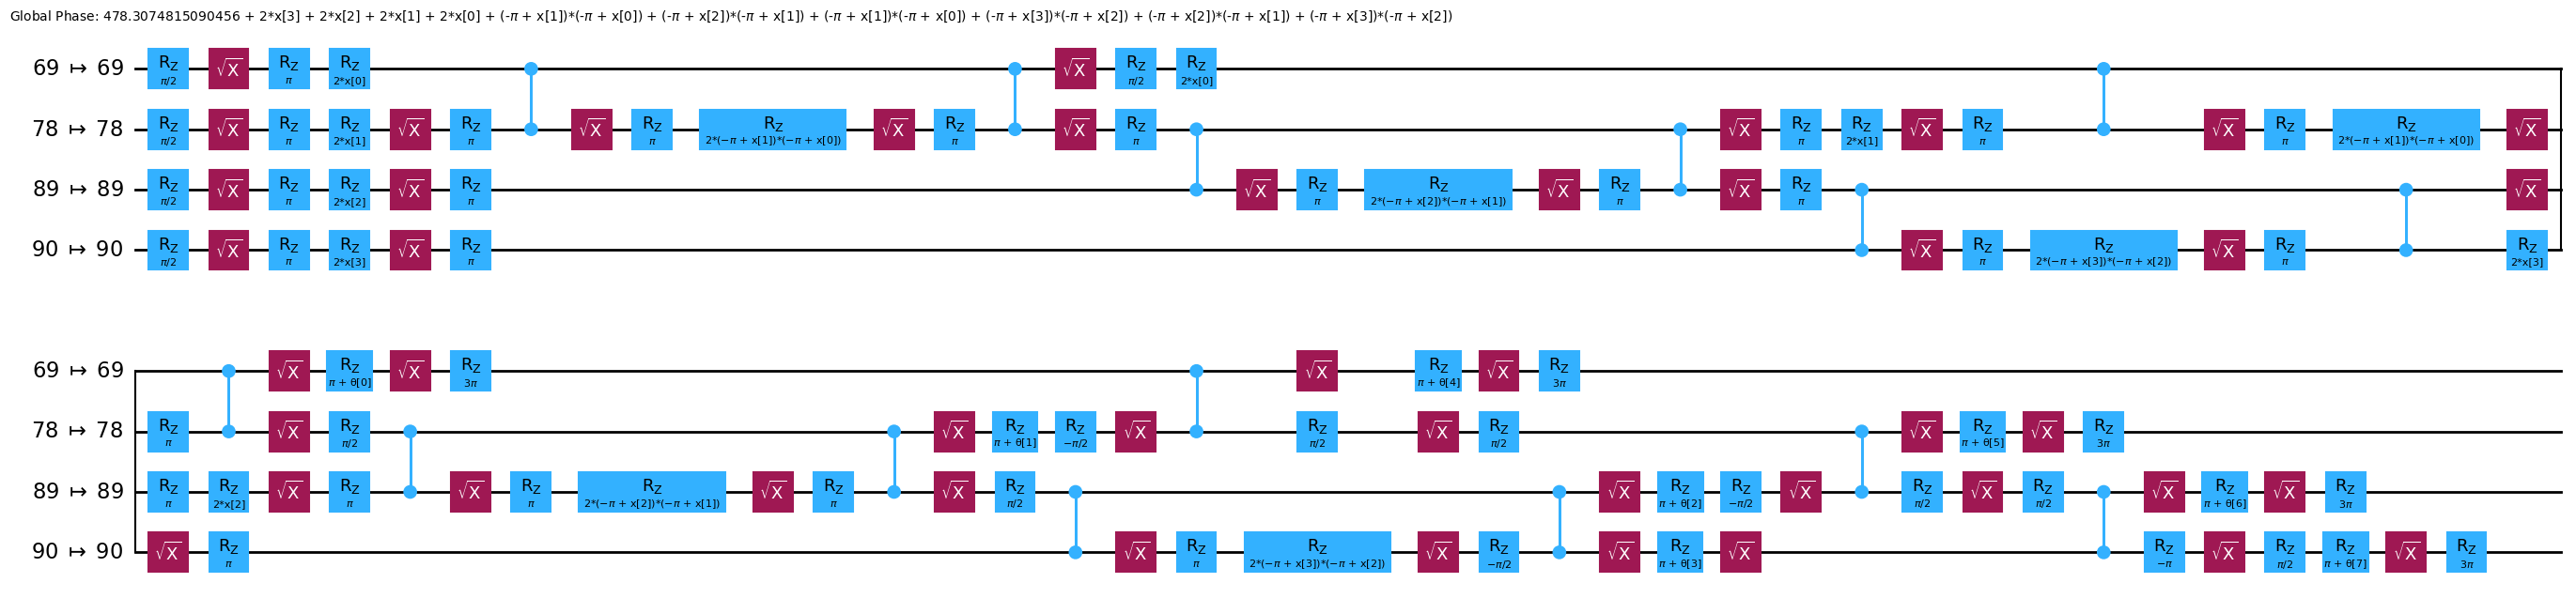

In [53]:
# Set up runtime service based on region
service = QiskitRuntimeService(name="freeya")

if USE_REAL_BACKEND:
    if REGION == 'us-east':
        service = QiskitRuntimeService(name="freeya-us") # In the case that we use a real backend, the region matters due to availability of backends.
                                                         # When we use simulations, regions do not matter so we can use a default QPU e.g. ibm_aachen

    # Get least busy real backend
    backend = service.least_busy(service.backends(
        filters=lambda b: not b.configuration().simulator and b.status().operational))
    
    session = Session(service=service, backend=backend)
    sampler = Sampler(session=session)

    print(f"Using real backend: {backend.name}")
else:
    # Use AerSimulator mimicking a real backend layout (Heron r2)
    real_backend = service.backend("ibm_aachen")  # Only used as template
    backend = AerSimulator().from_backend(real_backend)

    sampler = Sampler(mode=backend)
    print("Using AerSimulator based on ibm_aachen")

# Prepare pass manager
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

# Transpile and analyze the circuit
transpiled_circuit = pm.run(circuit)
depth_2q = transpiled_circuit.depth(lambda x: len(x.qubits) == 2)
print(f"Depth of two-qubit gates: {depth_2q}")

# Draw the circuit
transpiled_circuit.draw(output="mpl", idle_wires=False, fold=40)

### **Quantum Circuit Parameter Optimization**

This section optimizes the variational parameters of the quantum circuit using either **CMA-ES** or **COBYLA**, based on the `USE_CMA` flag.

#### **Optimizer Options**

* **CMA-ES** (Covariance Matrix Adaptation Evolution Strategy):

  * Evolutionary algorithm suitable for noisy or non-convex problems
  * Handles parameter noise using `cma.NoiseHandler`
  * Controlled by `CMA_ITER_COUNT`

* **COBYLA** (Constrained Optimization BY Linear Approximations):

  * Gradient-free optimizer based on linear approximations
  * Ideal for small parameter spaces and quick iterations
  * Controlled by `COBYLA_ITER_COUNT`

#### **Processing Details**

1. **Initialize Parameters**
   Randomly initialized in the range `[0, 2π]` to match typical rotation gate requirements for angle encoding.

2. **Define Objective Function**
   The cost function evaluates how well a given parameter set classifies training data.

3. **Run Optimization**
   Depending on the flag, either CMA-ES or COBYLA minimizes the cost over several iterations.

#### **Output**

* `optimized_params`: final optimized parameter vector
* Logs the completion message and which optimizer was used

In [54]:
cost_list = []

# For reproducibility
np.random.seed(RANDOM_STATE)

# Initialize parameters randomly in [0, 2π]
init_params = 2 * np.pi * np.random.rand(QUBIT_COUNT * 2 * 2)

# Define the objective function
objective_function = lambda params: cost_function(X_train, Y_train, params, cost_list, sampler, pm)

# Get number of parameters (from initial vector)
param_count = len(init_params)

# Choose optimizer
if USE_CMA:
    # CMA-ES optimizer (Covariance Matrix Adaptation Evolution Strategy - evolutionary strategy)

    print("Starting optimization using CMA-ES...\n")

    sigma0 = 0.1
    result = cma.fmin2(
        objective_function,
        x0=init_params,
        sigma0=sigma0,
        options = {
            'maxfevals': CMA_ITER_COUNT,
            'popsize': CMA_POPSIZE,
            'verb_disp': 0                             
        },
        noise_handler=cma.NoiseHandler(param_count)
    )
    optimized_params = result[0]
else:
    # COBYLA optimizer (Constrained Optimization BY Linear Approximations - derivative-free)

    print("Starting optimization using COBYLA...\n")
    
    result = minimize(
        objective_function,
        x0=init_params,
        method='COBYLA',
        options={'maxiter': COBYLA_ITER_COUNT}
    )
    optimized_params = result.x

print("Optimization finished. Check next cell for detailed results.")


Starting optimization using COBYLA...

[1/2]: Current cost (BCE) = 0.793327
[2/2]: Current cost (BCE) = 0.752994
Optimization finished. Check next cell for detailed results.


After our optimization run is finished we will be able to see the following detailed results:

In [55]:
if USE_CMA:
    print("Optimization completed using CMA-ES.")
    print("Optimized Parameters:", result[0])
    print("Final Cost Value:", result[1].best.f)
else:
    print("Optimization completed using COBYLA.")
    print("Optimized Parameters:", result.x)
    print("Final Cost Value:", result.fun)

Optimization completed using COBYLA.
Optimized Parameters: [3.35330497 5.97351416 4.59925358 3.76148219 0.98029403 0.98014248
 0.3649501  5.44234523 3.77691701 4.44895122 0.12933619 6.09412333
 5.23039137 1.33416598 1.14243996 1.15236452]
Final Cost Value: 0.7529941583440308


---

## **Result Visualization**

### **Cost Function Evolution**

This section visualizes the evolution of the cost function during the training of a variational quantum classifier.

We track how the cost value (Binary Cross-Entropy in our case) decreases as the optimizer adjusts the parameters over multiple steps.

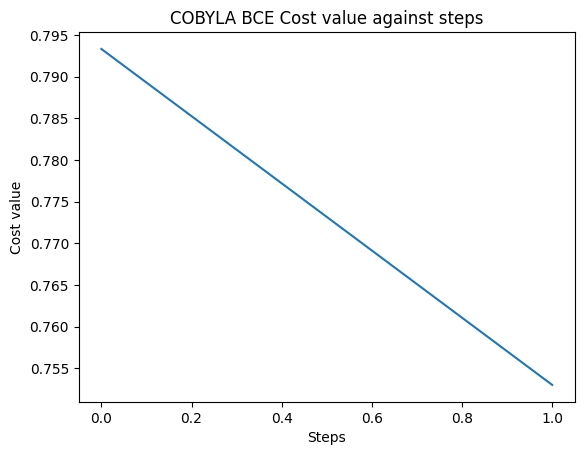

In [56]:
# Create a new figure for plotting
fig = plt.figure()

# Plot the cost value against optimization step index
plt.plot(range(len(cost_list)), cost_list)

# Label x and y axes
plt.xlabel('Steps')
plt.ylabel('Cost value')

# Set the plot title based on the optimizer used
if USE_CMA:
    plt.title("CMA-ES BCE Cost value against steps")
else:
    plt.title("COBYLA BCE Cost value against steps")

# Display the plot
plt.show()

### **Quantum Classifier Testing**

This function evaluates the accuracy of a trained quantum classifier on test data using a provided backend and transpiler.

#### **Processing Details**

* Predicts class probabilities for each test sample using `classify()`.
* Compares predicted label (`healthy` or `diseased`) with the true label.
* Computes the proportion of correct predictions as the test accuracy.
* Supports repeated evaluation to average out quantum noise or randomness.

#### **Output**

Prints individual and average test accuracy across multiple iterations.

In [57]:
def test_model(X: list, Y: list, params: list, sampler: any, pm: any) -> float:
    """
    Evaluate the accuracy of a trained quantum classifier on a test dataset.

    Args:
        X (list): Test feature samples.
        Y (list): Ground truth labels (0 = healthy, 1 = diseased).
        params (list): Optimized quantum circuit parameters.
        sampler: Quantum sampler backend to run the circuits. Either a simulator or a real quantum backend.
        pm: Quantum processor manager or transpiler to prepare circuits.

    Returns:
        float: Accuracy of the classifier on the test data.
    """
    correct = 0
    training_samples = X

    # Get class probability predictions for each test sample
    probs = classify(training_samples, params, sampler, pm)

    # Compare predictions with ground truth
    for i, prob in enumerate(probs):
        predicted_label = 0 if prob.get(CLASS_LABELS[0], 0) >= prob.get(CLASS_LABELS[1], 0) else 1
        true_label = Y[i]
        if predicted_label == true_label:
            correct += 1

    accuracy = correct / len(Y)
    print(f"Test Accuracy - {accuracy:.4f} ({correct}/{len(Y)} correct predictions)")
    return accuracy

Finally, we can test our model to check how well it classifies unseen data:

In [58]:
accuracies = []

print(f"Running model testing over {TEST_ITER_COUNT} iterations...\n")

# Run model multiple times and store accuracy
for i in range(TEST_ITER_COUNT):
    print(f"Iteration {i + 1}/{TEST_ITER_COUNT}...", end=" ")
    
    if USE_CMA:
        acc = test_model(X_test, Y_test, result[1].best.x, sampler, pm)
    else:
        acc = test_model(X_test, Y_test, result.x, sampler, pm)
    accuracies.append(acc)

# Compute statistics
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies, ddof=1)
conf_int = st.t.interval(0.95, len(accuracies) - 1, loc=mean_acc, scale=std_acc / np.sqrt(len(accuracies)))

# Print results
print("\n================= Final Evaluation =================")
print(f"Mean Accuracy:           {mean_acc:.4f}")
print(f"Standard Deviation:      {std_acc:.4f}")
print(f"95% Confidence Interval: [{conf_int[0]:.4f}, {conf_int[1]:.4f}]")
print("=========================================================")

Running model testing over 3 iterations...

Iteration 1/3... Test Accuracy - 0.2614 (23/88 correct predictions)
Iteration 2/3... Test Accuracy - 0.2386 (21/88 correct predictions)
Iteration 3/3... Test Accuracy - 0.2386 (21/88 correct predictions)

================= Final Evaluation =================
Mean Accuracy:           0.2462
Standard Deviation:      0.0131
95% Confidence Interval: [0.2136, 0.2788]


To save our results to be able to compare to them later if we modify parameters:

In [59]:
results = {
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "qubit_count": QUBIT_COUNT,
    "shot_count": SHOT_COUNT,
    "class_labels": CLASS_LABELS,
    "heart_data_path": HEART_DATA_PATH,
    "test_size": TEST_SIZE,
    "random_state": RANDOM_STATE,
    "optimizer": "CMA-ES" if USE_CMA else "COBYLA",
    "optimizer_iterations": CMA_ITER_COUNT if USE_CMA else COBYLA_ITER_COUNT,
    "cma_popsize": CMA_POPSIZE if USE_CMA else None,
    "use_real_backend": USE_REAL_BACKEND,
    "backend": backend.name,
    "region": REGION,
    "test_iterations": TEST_ITER_COUNT,
    "mean_accuracy": round(mean_acc, 4),
    "std_deviation": round(std_acc, 4),
    "confidence_interval": [round(conf_int[0], 4), round(conf_int[1], 4)],
    "cost_list": cost_list
}

# Output filename with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"evaluation_results_{timestamp}.json"
output_dir = "results"

# Ensure directory exists
os.makedirs(output_dir, exist_ok=True)

# Save as JSON
with open(os.path.join(output_dir, filename), "w") as f:
    json.dump(results, f, indent=4)

print(f"\n📁 Results saved to: {os.path.join(output_dir, filename)}")


📁 Results saved to: results\evaluation_results_20250717_220024.json


**Optional**: Compare to a different run

In [ ]:
def load_comparison_run(current_optimizer, custom_name=None):
    results_path = "results"
    if custom_name:
        # User-specified filename
        file_path = os.path.join(results_path, f"{custom_name}.json")
        if os.path.exists(file_path):
            return json.load(open(file_path))
        else:
            print(f"⚠️ File '{custom_name}.json' not found in 'results/'.")
            return None
    else:
        # Automatically find the latest result from the *other* optimizer
        files = sorted(glob.glob(os.path.join(results_path, "evaluation_results_*.json")), reverse=True)
        for f in files:
            with open(f) as file:
                data = json.load(file)
                if data["optimizer"] != current_optimizer:
                    return data
        print("No previous run found using the other optimizer.")
        return None

In [63]:
def compare_configurations(current, previous, keys_to_check):
    diffs = []
    for key in keys_to_check:
        current_val = current.get(key, None)
        previous_val = previous.get(key, None)
        if current_val != previous_val:
            diffs.append((key, previous_val, current_val))
    return diffs

In [65]:
COMPARE_TO = None  # Set this to the filename without .json if you want a specific one (e.g., "evaluation_results_20250716_180000")
comparison = load_comparison_run("CMA-ES" if USE_CMA else "COBYLA", COMPARE_TO)

if comparison:
    print("\n================= Comparison with Previous Run =================")
    print(f"Previous Run Timestamp:  {comparison['timestamp']}")
    print(f"Optimizer Used:          {comparison['optimizer']}")
    print(f"Mean Accuracy:           {comparison['mean_accuracy']:.4f}")
    print(f"Standard Deviation:      {comparison['std_deviation']:.4f}")
    ci = comparison['confidence_interval']
    print(f"95% Confidence Interval: [{ci[0]:.4f}, {ci[1]:.4f}]")

    # Accuracy delta
    delta = mean_acc - comparison['mean_accuracy']
    better = "↑ Better" if delta > 0 else "↓ Worse" if delta < 0 else "→ Same"
    print(f"\nAccuracy delta vs previous: {delta:.4f} ({better})")

    # Check for differing run parameters
    print("\nConfiguration Differences:")
    keys_to_check = [
        "qubit_count", "shot_count", "test_size", "random_state",
        "optimizer", "optimizer_iterations", "cma_popsize", 
        "use_real_backend", "region", "test_iterations", "heart_data_path"
    ]
    config_diffs = compare_configurations(results, comparison, keys_to_check)

    if config_diffs:
        for key, old, new in config_diffs:
            print(f" - {key}: previous = {old} | current = {new}")
    else:
        print(" - None (All matching)")

    print("===============================================================")




================= Comparison with Previous Run =================
Previous Run Timestamp:  2025-07-17 21:54:50
Optimizer Used:          CMA-ES
Mean Accuracy:           0.5530
Standard Deviation:      0.0473
95% Confidence Interval: [0.4355, 0.6706]

Accuracy delta vs previous: -0.3068 (↓ Worse)

Configuration Differences:
 - optimizer: previous = CMA-ES | current = COBYLA
 - optimizer_iterations: previous = 15 | current = 2
 - cma_popsize: previous = 20 | current = None
